# FloPy

## Making Cross Sections of Your Model
This notebook demonstrates the cross sectional mapping capabilities of FloPy. It demonstrates these capabilities by loading and running existing models and then showing how the `PlotCrossSection` object and its methods can be used to make nice plots of the model grid, boundary conditions, model results, shape files, etc.

### Mapping is demonstrated for MODFLOW-2005 and MODFLOW-6 models in this notebook

In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

sys.path.append(os.path.join("..", "common"))
import notebook_utils

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version: 1.23.1
matplotlib version: 3.5.2
flopy version: 3.3.6


In [2]:
# Set names of the MODFLOW exes
# assumes that the executable is in users path statement
v2005 = "mf2005"
exe_name_2005 = "mf2005"
vmf6 = "mf6"
exe_name_mf6 = "mf6"
exe_mp = "mp6"
if platform.system() == "Windows":
    exe_name_2005 += ".exe"
    exe_name_mf6 += ".exe"
    exe_mp += ".exe"

# Set the paths
prj_root = notebook_utils.get_project_root_path()
loadpth = str(prj_root / "examples" / "data" / "freyberg")
tempdir = TemporaryDirectory()
modelpth = tempdir.name

### Load and Run an Existing MODFLOW-2005 Model
A model called the "Freyberg Model" is located in the loadpth folder.  In the following code block, we load that model, then change into a new workspace (modelpth) where we recreate and run the model.  For this to work properly, the MODFLOW-2005 executable (mf2005) must be in the path.  We verify that it worked correctly by checking for the presence of freyberg.hds and freyberg.cbc.

In [3]:
ml = flopy.modflow.Modflow.load(
    "freyberg.nam", model_ws=loadpth, exe_name=exe_name_2005, version=v2005
)
ml.change_model_ws(new_pth=str(modelpth))
ml.write_input()
success, buff = ml.run_model()
if not success:
    print("Something bad happened.")
files = ["freyberg.hds", "freyberg.cbc"]
for f in files:
    if os.path.isfile(os.path.join(str(modelpth), f)):
        msg = "Output file located: {}".format(f)
        print(msg)
    else:
        errmsg = "Error. Output file cannot be found: {}".format(f)
        print(errmsg)

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:16:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:16:03
 Elapsed run time:  0.009 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc


### Creating a Cross-Section of the Model Grid

Now that we have a model, we can use the FloPy plotting utilities to make cross-sections. We'll start by making a Map to show the model grid and basic boundary conditions. Then we'll begin making a cross section using the `PlotCrossSection` class and the `plot_grid()` method of that class.

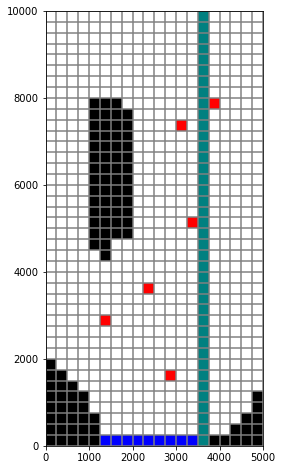

In [4]:
# let's take a look at our grid before making a cross section
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=ml)
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
riv = mapview.plot_bc("RIV")
linecollection = mapview.plot_grid()

Next we will make a cross-section of the model grid at column 6.

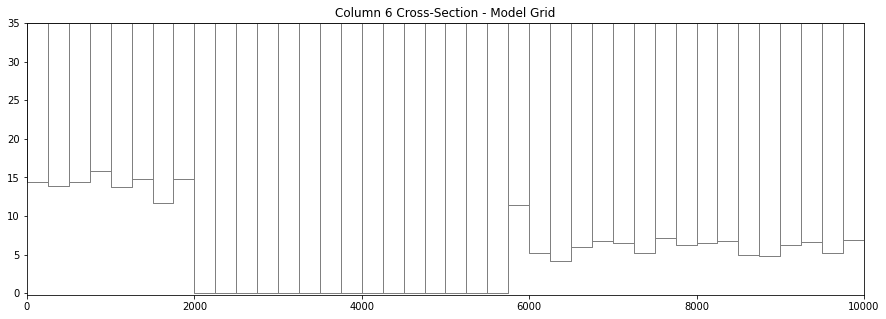

In [5]:
# First step is to set up the plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section - Model Grid")

### Ploting Ibound

The `plot_ibound()` method can be used to plot the boundary conditions contained in the ibound arrray, which is part of the MODFLOW Basic Package.  The `plot_ibound()` method returns a matplotlib PatchCollection object (matplotlib.collections.PatchCollection).  If you are familiar with the matplotlib collections, then this may be important to you, but if not, then don't worry about the return objects of these plotting function.

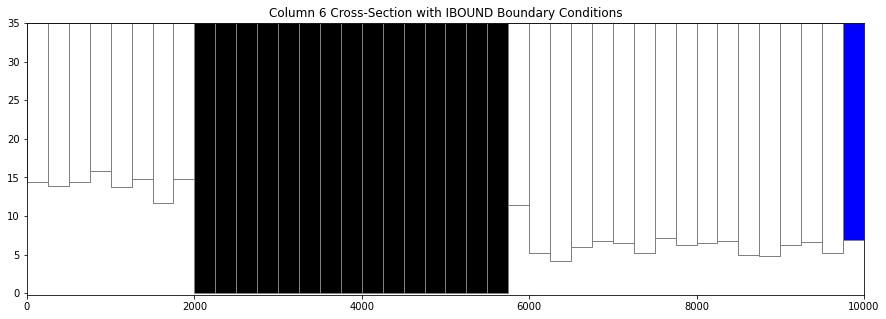

In [6]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section with IBOUND Boundary Conditions")

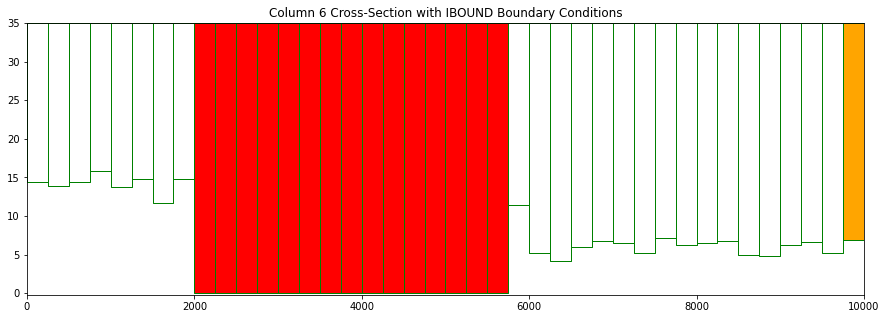

In [7]:
# Or we could change the colors!
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
patches = xsect.plot_ibound(color_noflow="red", color_ch="orange")
linecollection = xsect.plot_grid(color="green")
t = ax.set_title("Column 6 Cross-Section with IBOUND Boundary Conditions")

### Plotting Boundary Conditions
The `plot_bc()` method can be used to plot boundary conditions on a cross section.  It is setup to use the following dictionary to assign colors, however, these colors can be changed in the method call.

    bc_color_dict = {'default': 'black', 'WEL': 'red', 'DRN': 'yellow',
                 'RIV': 'green', 'GHB': 'cyan', 'CHD': 'navy'}

Just like the `plot_bc()` method for `PlotMapView`, the default boundary condition colors can be changed in the method call.

Here, we plot the location of well cells in column 6.

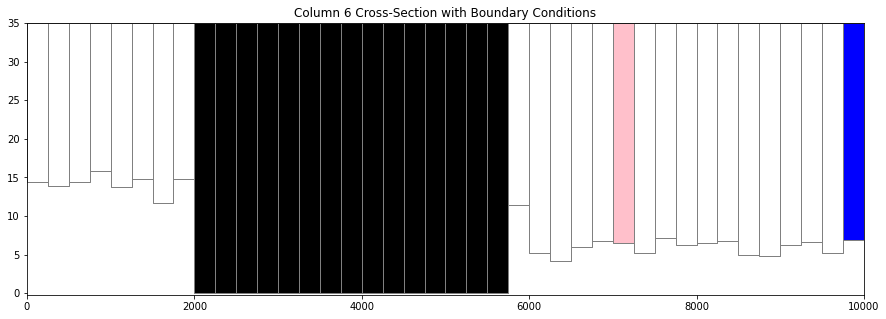

In [8]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
patches = xsect.plot_bc("WEL", color="pink")
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section with Boundary Conditions")

### Plotting an Array

`PlotCrossSection` has a `plot_array()` method.  The `plot_array()` method will only accept 3D arrays for structured grids.  

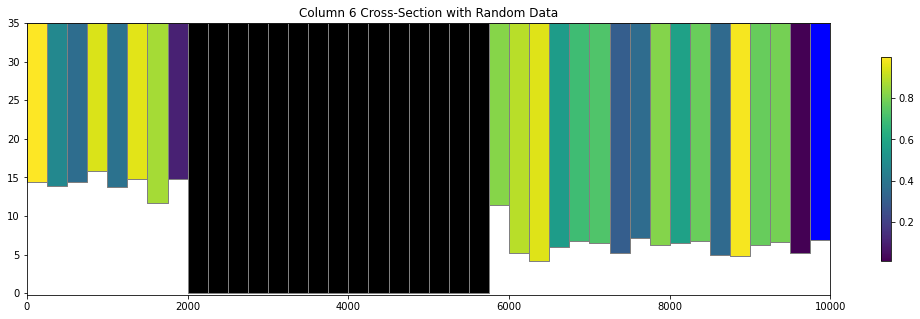

In [9]:
# Create a random array and plot it
a = np.random.random((ml.dis.nlay, ml.dis.nrow, ml.dis.ncol))

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
csa = xsect.plot_array(a)
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section with Random Data")
cb = plt.colorbar(csa, shrink=0.75)

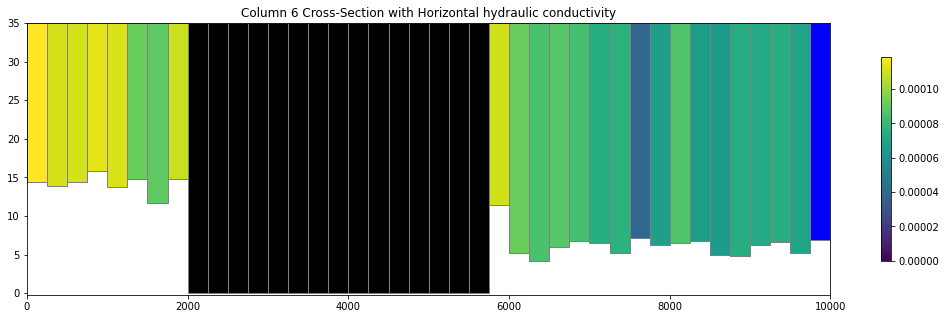

In [10]:
# plot the horizontal hydraulic conductivities
a = ml.lpf.hk.array

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
csa = xsect.plot_array(a)
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title(
    "Column 6 Cross-Section with Horizontal hydraulic conductivity"
)
cb = plt.colorbar(csa, shrink=0.75)

### Contouring an Array

`PlotCrossSection` also has a `contour_array()` method.  It also accepts a 3D array for structured grids.

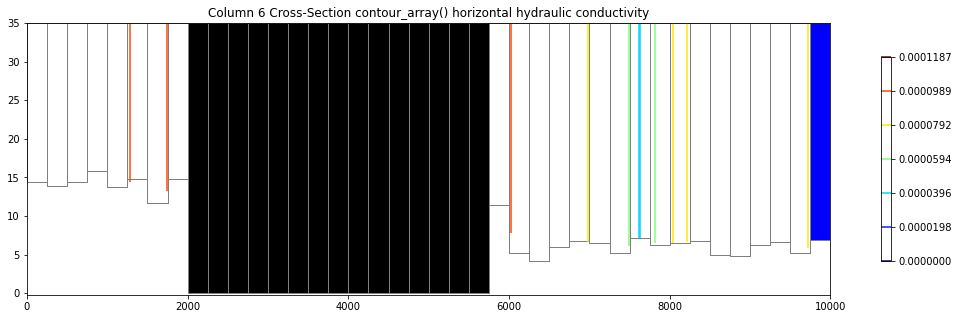

In [11]:
# plot the horizontal hydraulic conductivities
a = ml.lpf.hk.array

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
contour_set = xsect.contour_array(a, masked_values=[0], cmap="jet")
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid(color="grey")
t = ax.set_title(
    "Column 6 Cross-Section contour_array() horizontal hydraulic conductivity"
)
cb = plt.colorbar(contour_set, shrink=0.75)

### Plotting Heads

We can easily plot results from the simulation by extracting heads using `flopy.utils.HeadFile`. 

The head can be passed into the `plot_array()` and `contour_array()` using the `head=` keyword argument to fix the top of the colored patch and contour lines at the top of the water table in each cell, respectively. 

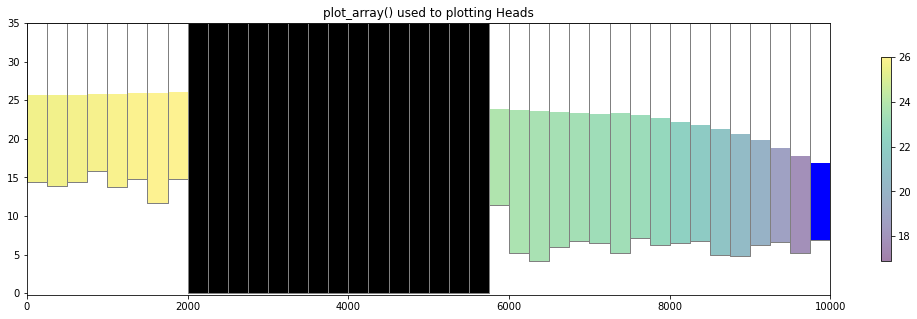

In [12]:
fname = os.path.join(str(modelpth), "freyberg.hds")
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array() used to plotting Heads")
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})
pc = xsect.plot_array(head, masked_values=[999.0], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
cb = plt.colorbar(pc, shrink=0.75)

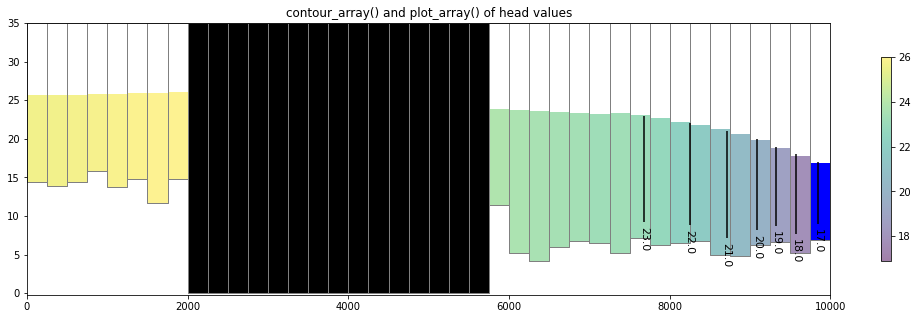

In [13]:
# contour array on top of heads
levels = np.arange(17, 26, 1)

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("contour_array() and plot_array() of head values")

# instantiate the PlotCrossSection object
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})

# plot the head array and model grid
pc = xsect.plot_array(head, masked_values=[999.0], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()

# do black contour lines of the head array
contour_set = xsect.contour_array(
    head, masked_values=[999.0], head=head, levels=levels, colors="k"
)
plt.clabel(contour_set, fmt="%.1f", colors="k", fontsize=11)

cb = plt.colorbar(pc, shrink=0.75)

### Plotting a surface on the cross section

The `plot_surface()` method allows the user to plot a surface along the cross section. Here is a short example using head data.

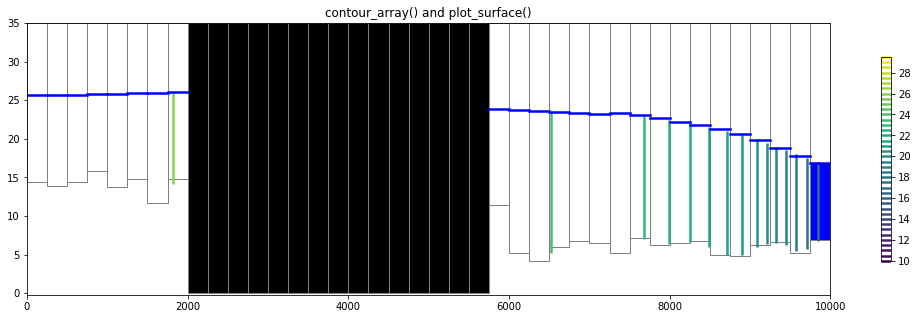

In [14]:
levels = np.arange(10, 30, 0.5)

fig = plt.figure(figsize=(18, 5))
xsect = flopy.plot.PlotCrossSection(model=ml, line={"Column": 5})

# contour array and plot ibound
ct = xsect.contour_array(
    head, masked_values=[999.0], head=head, levels=levels, linewidths=2.5
)
pc = xsect.plot_ibound(head=head)

# plot the surface and model grid
wt = xsect.plot_surface(head, masked_values=[999.0], color="blue", lw=2.5)
linecollection = xsect.plot_grid()

plt.title("contour_array() and plot_surface()")
cb = plt.colorbar(ct, shrink=0.75)

### Plotting discharge vectors

`PlotCrossSection` has a `plot_vector()` method, which takes `qx`, `qy`, and `qz` vector arrays (ex. specific discharge or flow across a cell faces). The flow array values can be extracted from the cell by cell flow file using the `flopy.utils.CellBudgetFile` object as shown below.  Once they are extracted, they either be can be passed to the `plot_vector()` method or they can be post processed into specific discharge using `postprocessing.get_specific_discharge`.  Note that `get_specific_discharge()` also takes the head array as an argument.  The head array is used by `get_specific_discharge()` to convert the volumetric flow in dimensions of $L^3/T$ to specific discharge in dimensions of $L/T$ and to plot the specific discharge in the center of each saturated cell. For this problem, there is no 'FLOW LOWER FACE' array since the Freyberg Model is a one layer model.

In [15]:
fname = os.path.join(str(modelpth), "freyberg.cbc")
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text="FLOW RIGHT FACE")[0]
fff = cbb.get_data(text="FLOW FRONT FACE")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf, fff, None), ml, head=head
)

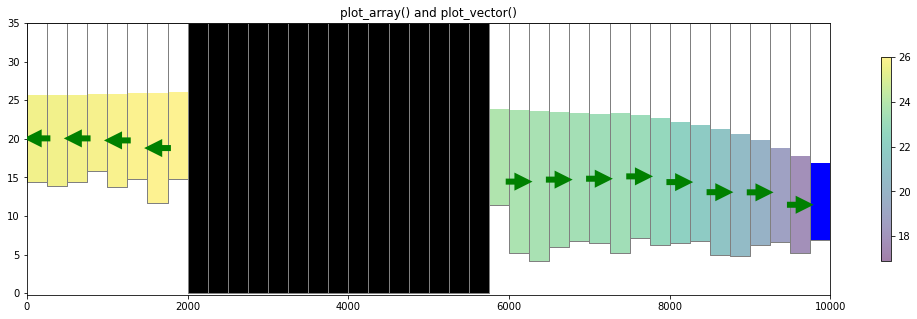

In [16]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("plot_array() and plot_vector()")
xsect = flopy.plot.PlotCrossSection(model=ml, ax=ax, line={"Column": 5})
csa = xsect.plot_array(head, masked_values=[999.0], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
quiver = xsect.plot_vector(
    qx,
    qy,
    qz,
    head=head,
    hstep=2,
    normalize=True,
    color="green",
    scale=30,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    zorder=10,
)

cb = plt.colorbar(csa, shrink=0.75)

### Plotting a cross section from Shapefile data

A shapefile can be used to define the vertices for a instance of the `PlotCrossSection` class. The function `flopy.plot.plotutil.shapefile_get_vertices()` will return a list of vertices for each polyline in a shapefile.

Let's plot the shapefiles and the Freyberg model using `PlotMapView` for visualization purposes and then plot the cross-section.

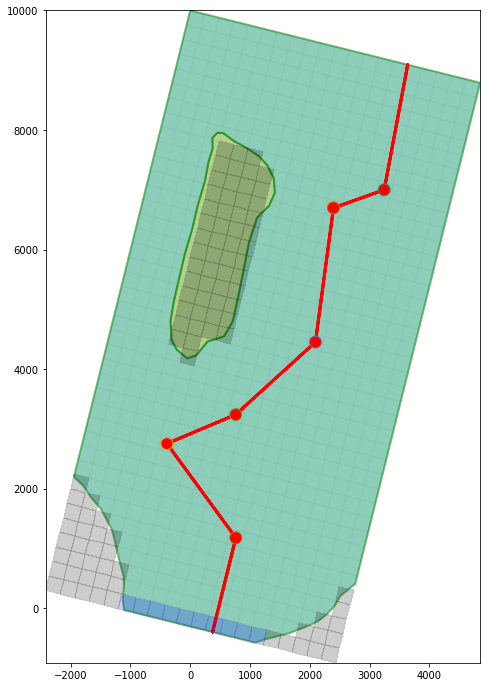

In [17]:
# Setup the figure and PlotMapView. Show a very faint map of ibound and
# model grid by specifying a transparency alpha value.

# set the modelgrid rotation and offset
ml.modelgrid.set_coord_info(
    xoff=-2419.2189559966773, yoff=297.0427372400354, angrot=-14
)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=ml)

# Plot a shapefile of
shp = os.path.join(loadpth, "gis", "bedrock_outcrop_hole_rotate14")
patch_collection = mapview.plot_shapefile(
    shp, edgecolor="green", linewidths=2, alpha=0.5  # facecolor='none',
)
# Plot a shapefile of a cross-section line
shp = os.path.join(loadpth, "gis", "cross_section_rotate14")
patch_collection = mapview.plot_shapefile(
    shp, radius=0, lw=3, edgecolor="red", facecolor="None"
)

# Plot a shapefile of well locations
shp = os.path.join(loadpth, "gis", "wells_locations_rotate14")
patch_collection = mapview.plot_shapefile(shp, radius=100, facecolor="red")

# Plot the grid and boundary conditions over the top
quadmesh = mapview.plot_ibound(alpha=0.1)
linecollection = mapview.plot_grid(alpha=0.1);

Now let's make a cross section based on this arbitrary cross-sectional line. We can load the cross sectional line vertices using `flopy.plot.plotutil.shapefile_get_vertices()`

**Note**: in previous examples we passed `line={'column', 5}` to plot a cross section along a column. In this example we pass vertex information into `PlotCrossSection` using `line={'line', line[0]}` where `line[0]` is a list of vertices.

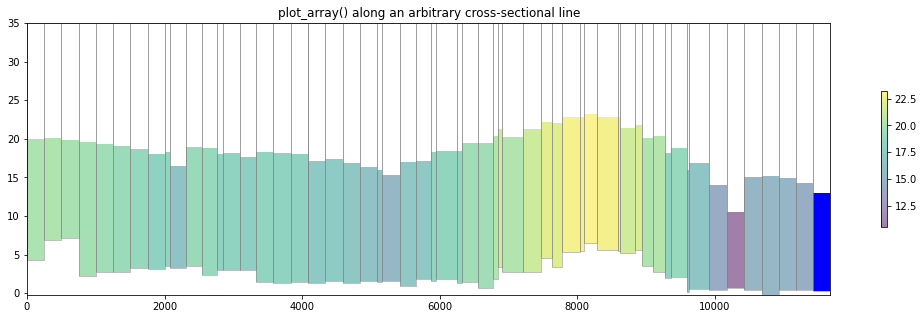

In [18]:
# get the vertices for cross-section lines in a shapefile
fpth = os.path.join(loadpth, "gis", "cross_section_rotate14")
line = flopy.plot.plotutil.shapefile_get_vertices(fpth)

# Set up the figure
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array() along an arbitrary cross-sectional line")

# plot head values along the cross sectional line
xsect = flopy.plot.PlotCrossSection(model=ml, line={"line": line[0]})
csa = xsect.plot_array(head, masked_values=[999.0], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid(lw=0.5)
cb = fig.colorbar(csa, ax=ax, shrink=0.5)

### Plotting geographic coordinates on the x-axis using the `PlotCrossSection` class

The default cross section plotting method plots cells with regard to their intersection distance along the cross sectional line defined by the user. While this method is perfectly acceptable and in many cases may be preferred for plotting arbitrary cross sections, a flag has been added to plot based on geographic coordinates.

The flag `geographic_coords` defaults to `False` which maintains FloPy's previous method of plotting cross sections. 

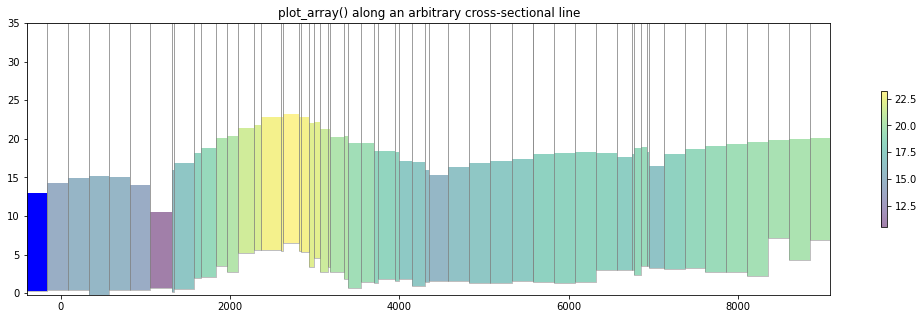

In [19]:
# get the vertices for cross-section lines in a shapefile
fpth = os.path.join(loadpth, "gis", "cross_section_rotate14")
line = flopy.plot.plotutil.shapefile_get_vertices(fpth)

# Set up the figure
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array() along an arbitrary cross-sectional line")

# plot head values along the cross sectional line
xsect = flopy.plot.PlotCrossSection(
    model=ml, line={"line": line[0]}, geographic_coords=True
)
csa = xsect.plot_array(head, masked_values=[999.0], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid(lw=0.5)
cb = fig.colorbar(csa, ax=ax, shrink=0.5)

## Plotting Cross Sections with MODFLOW-6 models

`PlotCrossSection` has support for MODFLOW-6 models and operates in the same fashion for Structured Grids, Vertex Grids, and Unstructured Grids. Here is a short example on how to plot with MODFLOW-6 structured grids using a version of the Freyberg model created for MODFLOW-6|

In [20]:
# load the Freyberg model into mf6-flopy and run the simulation
sim_name = "mfsim.nam"
sim_path = str(prj_root / "examples" / "data" / "mf6-freyberg")
sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name, version=vmf6, exe_name=exe_name_mf6, sim_ws=sim_path
)

sim.set_sim_path(modelpth)
sim.write_simulation()
success, buff = sim.run_simulation()
if not success:
    print("Something bad happened.")
files = ["freyberg.hds", "freyberg.cbc"]
for f in files:
    if os.path.isfile(os.path.join(str(modelpth), f)):
        msg = "Output file located: {}".format(f)
        print(msg)
    else:
        errmsg = "Error. Output file cannot be found: {}".format(f)
        print(errmsg)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading ims package freyberg...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package freyberg...
  writing model freyberg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package riv_0...
    writing package wel_0...
    writing package rch_0...
FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULA

### Plotting boundary conditions and arrays

This works the same as modflow-2005, however the simulation object can host a number of modflow-6 models so we need to grab a model before attempting to plot with `PlotCrossSection`

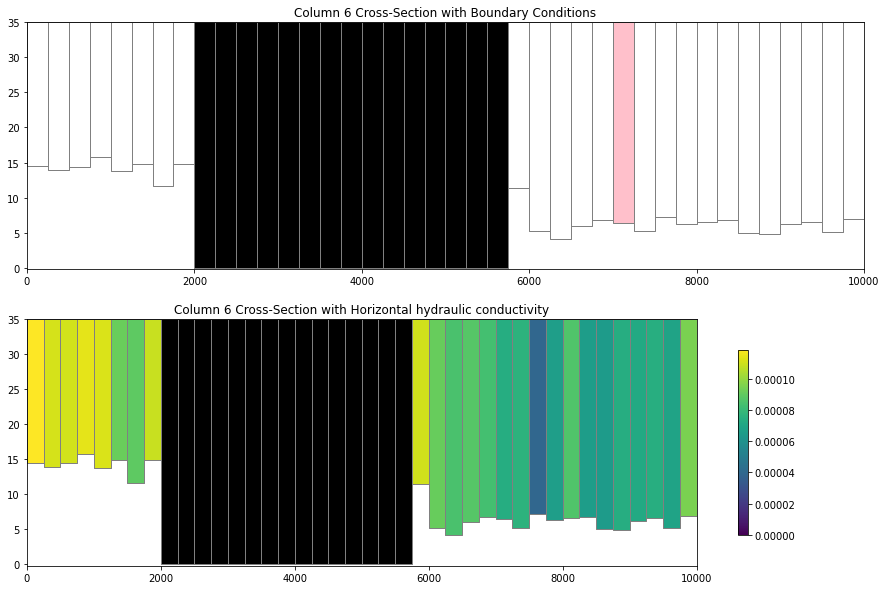

In [21]:
# get the modflow-6 model we want to plot
ml6 = sim.get_model("freyberg")

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 1, 1)

# plot boundary conditions
xsect = flopy.plot.PlotCrossSection(model=ml6, line={"Column": 5})
patches = xsect.plot_bc("WEL_0", color="pink")
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section with Boundary Conditions")

# plot xxxx
ax = fig.add_subplot(2, 1, 2)
# plot the horizontal hydraulic conductivities
a = ml6.npf.k.array

xsect = flopy.plot.PlotCrossSection(model=ml6, line={"Column": 5})
csa = xsect.plot_array(a)
patches = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title(
    "Column 6 Cross-Section with Horizontal hydraulic conductivity"
)
cb = plt.colorbar(csa, shrink=0.75)

### Plotting specific discharge with a MODFLOW-6 model

MODFLOW-6 includes a the PLOT_SPECIFIC_DISCHARGE flag in the NPF package to calculate and store discharge vectors for easy plotting. The `postprocessing.get_specific_discharge()` method will preprocess the data into vectors and `PlotCrossSection` has the `plot_vector()` method to use this data. The specific discharge array is stored in the cell budget file.

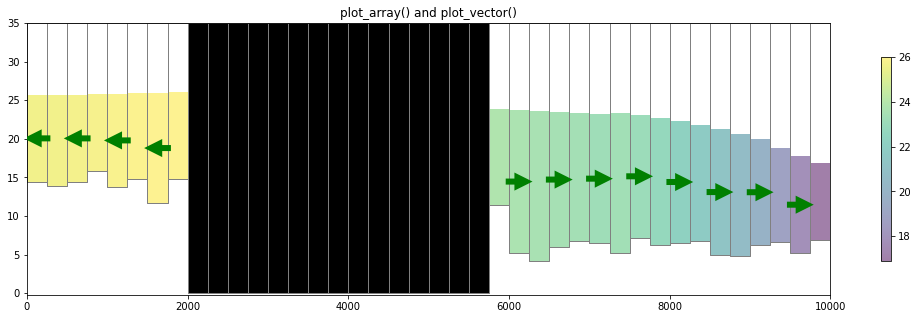

In [22]:
# get the head from the head file
head_file = os.path.join(modelpth, "freyberg.hds")
hds = flopy.utils.HeadFile(head_file)
head = hds.get_alldata()[0]

# get the specific discharge from the cell budget file
cbc_file = os.path.join(modelpth, "freyberg.cbc")
cbc = flopy.utils.CellBudgetFile(cbc_file, precision="double")
spdis = cbc.get_data(text="SPDIS")[-1]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    spdis, ml6, head=head
)

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("plot_array() and plot_vector()")
xsect = flopy.plot.PlotCrossSection(model=ml6, ax=ax, line={"Column": 5})
csa = xsect.plot_array(head, masked_values=[1e30], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
quiver = xsect.plot_vector(
    qx,
    qy,
    qz,
    head=head,
    hstep=2,
    normalize=True,
    color="green",
    scale=30,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    zorder=10,
)

cb = plt.colorbar(csa, shrink=0.75)

## Vertex cross section plotting with MODFLOW-6 (DISV) 

FloPy fully supports vertex discretization (DISV) plotting through the `PlotCrossSection` class. The method calls are identical to the ones presented previously for Structured discretization (DIS) and the same matplotlib keyword arguments are supported. Let's run through an example using a vertex model grid.

In [23]:
# build and run vertex model grid demo problem
notebook_utils.run(modelpth)

# check if model ran properly
modelpth = os.path.join(modelpth, "mp7_ex2", "mf6")
# from pprint import pprint
# pprint([str(p) for p in (Path(tempdir.name) / "mp7_ex2").glob('*')])
files = ["mp7p2.hds", "mp7p2.cbb"]
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = "Output file located: {}".format(f)
        print(msg)
    else:
        errmsg = "Error. Output file cannot be found: {}".format(f)
        print(errmsg)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mp7p2...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
      

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:16:08
 Elapsed run time:  0.124 Seconds
 

WARNING REPORT:

  1. NONLINEAR BLOCK VARIABLE 'OUTER_HCLOSE' IN FILE 'mp7p2.ims' WAS
     DEPRECATED IN VERSION 6.1.1. SETTING OUTER_DVCLOSE TO OUTER_HCLOSE VALUE.
  2. LINEAR BLOCK VARIABLE 'INNER_HCLOSE' IN FILE 'mp7p2.ims' WAS DEPRECATED
     IN VERSION 6.1.1. SETTING INNER_DVCLOSE TO INNER_HCLOSE VALUE.
 Normal termination of simulation.
FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
        16 particles terminated at boundary faces.
         0 particles term

In [24]:
# load the simulation and get the model
vertex_sim_name = "mfsim.nam"
vertex_sim = flopy.mf6.MFSimulation.load(
    sim_name=vertex_sim_name,
    version=vmf6,
    exe_name=exe_name_mf6,
    sim_ws=modelpth,
)
vertex_ml6 = vertex_sim.get_model("mp7p2")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...


    loading package ic...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package riv...
    loading package oc...
  loading ims package mp7p2...


### Plotting a line based cross section through the model grid

Because Vertex model grids have no row or column number, cross sections through the model grid must be defined by a set of vertices and passed to the `PlotCrossSection` class using the parameter `line={"line": [(), (), ...]`. Below we show an example of setting up a cross sectional line with a MODFLOW-6 vertex grid model.


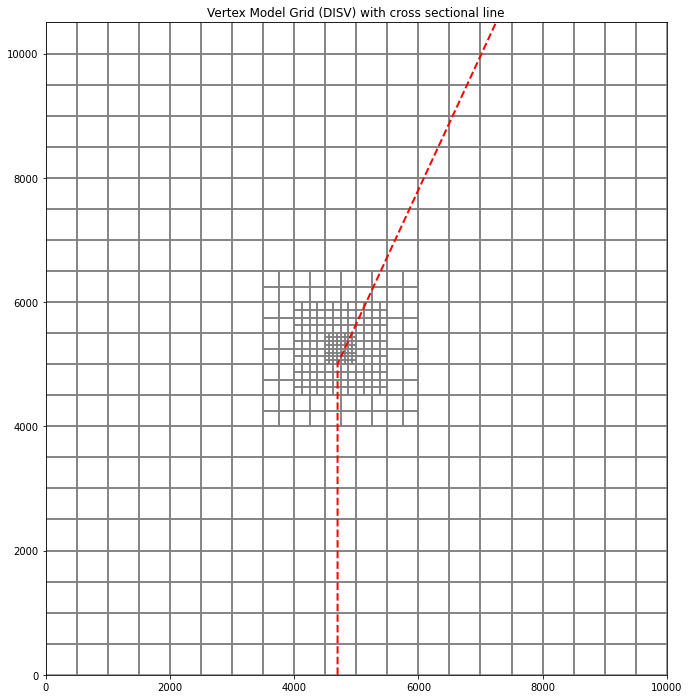

In [25]:
line = np.array([(4700, 0), (4700, 5000), (7250, 10500)])

# Let's plot the model grid in map view to look at it
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Vertex Model Grid (DISV) with cross sectional line")

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(vertex_ml6, layer=0)
linecollection = mapview.plot_grid()

# plot the line over the model grid
lc = plt.plot(line.T[0], line.T[1], "r--", lw=2)

Now we can plot a cross section of the model grid defined by this line

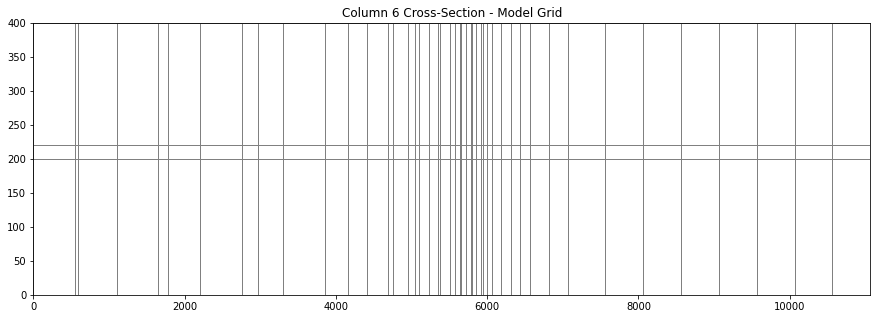

In [26]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = xsect.plot_grid()
t = ax.set_title("Column 6 Cross-Section - Model Grid")

### Plotting Arrays and Contouring with Vertex Model grids

`PlotCrossSection` allows the user to plot arrays and contour with DISV based discretization. The `plot_array()` method is called in the same way as using a structured grid. The only difference is that `PlotCrossSection` builds a matplotlib patch collection for Vertex based grids. 

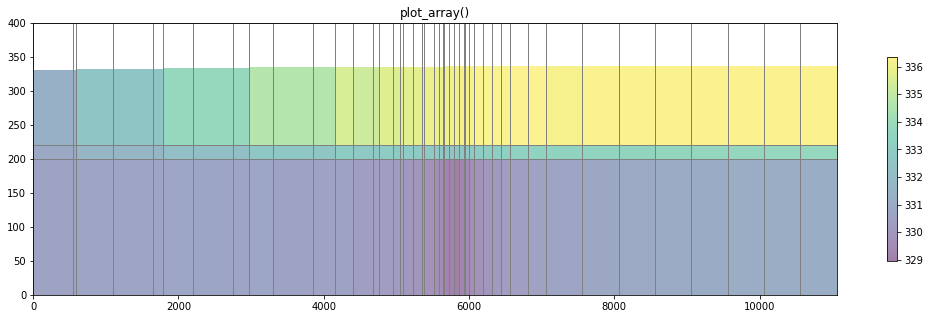

In [27]:
# get the head output for stress period 1 from the modflow6 head file
head = flopy.utils.HeadFile(os.path.join(modelpth, "mp7p2.hds"))
hdata = head.get_alldata()[0, :, :, :]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array()")

xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

The `contour_array()` method operates in the same way as the sturctured example.

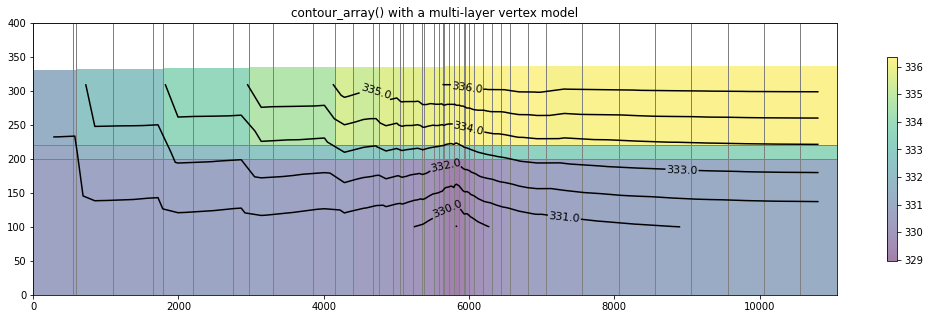

In [28]:
levels = np.arange(329, 337, 1)

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("contour_array() with a multi-layer vertex model")

xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()

contour_set = xsect.contour_array(hdata, levels=levels, colors="k")
plt.clabel(contour_set, fmt="%.1f", colors="k", fontsize=11)

cb = plt.colorbar(patch_collection, shrink=0.75)

### Plotting specific discharge vectors for DISV
MODFLOW-6 includes a the PLOT_SPECIFIC_DISCHARGE flag in the NPF package to calculate and store discharge vectors for easy plotting.The `postprocessing.get_specific_discharge()` method will preprocess the data into vectors and `PlotCrossSection` has the `plot_vector()` method to use this data. The specific discharge array is stored in the cell budget file.

**Note**: When plotting specific discharge, an arbitrary cross section cannot be used. The cross sectional line must be orthogonal to the model grid

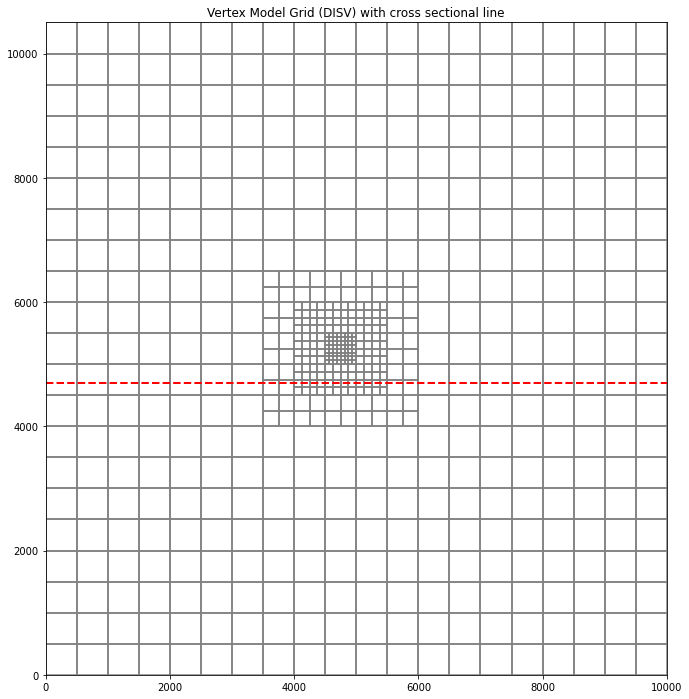

In [29]:
# define and plot our orthogonal line
line = np.array([(0, 4700), (10000, 4700)])

# Let's plot the model grid in map view to look at it
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Vertex Model Grid (DISV) with cross sectional line")

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(vertex_ml6, layer=0)
linecollection = mapview.plot_grid()

# plot the line over the model grid
lc = plt.plot(line.T[0], line.T[1], "r--", lw=2)

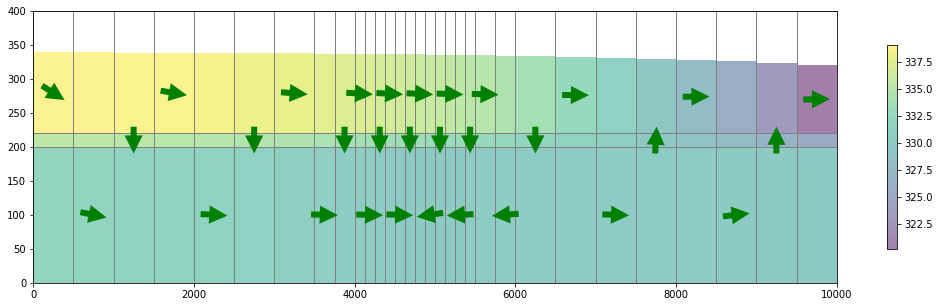

In [30]:
# plot specific discharge on cross section
cbb = flopy.utils.CellBudgetFile(os.path.join(modelpth, "mp7p2.cbb"))
spdis = cbb.get_data(text="SPDIS")[-1]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    spdis, vertex_ml6, head=hdata
)

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()
quiver = xsect.plot_vector(
    qx,
    qy,
    qz,
    head=hdata,
    hstep=3,
    normalize=True,
    color="green",
    scale=30,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    zorder=10,
)

cb = plt.colorbar(patch_collection, shrink=0.75)

## Plotting using built in styles

FloPy's plotting routines can be used with built in styles from the `styles` module. The `styles` module takes advantage of matplotlib's temporary styling routines by reading in pre-built style sheets. Two different types of styles have been built for flopy: `USGSMap()` and `USGSPlot()` styles which can be used to create report quality figures. The styles module also contains a number of methods that can be used for adding axis labels, text, annotations, headings, removing tick lines, and updating the current font.

This example will load the Keating groundwater transport model and plot results using `styles`

In [31]:
notebook_utils.run_keating_model(modelpth)

Running mf6gwf model...


Running mf6gwt model...


True

Load the flow and transport models

In [32]:
sim_path = os.path.join(modelpth, "mf6-gwt-keating", "mf6gwf")
tr_path = os.path.join(modelpth, "mf6-gwt-keating", "mf6gwt")
sim_name = "mfsim.nam"
sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name, version=vmf6, exe_name=exe_name_mf6, sim_ws=sim_path
)
gwf6 = sim.get_model("flow")

sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name, version=vmf6, exe_name=exe_name_mf6, sim_ws=tr_path
)
gwt6 = sim.get_model("trans")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...


    loading package ic...
    loading package chd...
    loading package rch...
    loading package oc...
  loading ims package flow...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package mst...
    loading package adv...
    loading package dsp...
    loading package fmi...
    loading package ssm...
    loading package oc...
    loading package obs...
  loading ims package trans...


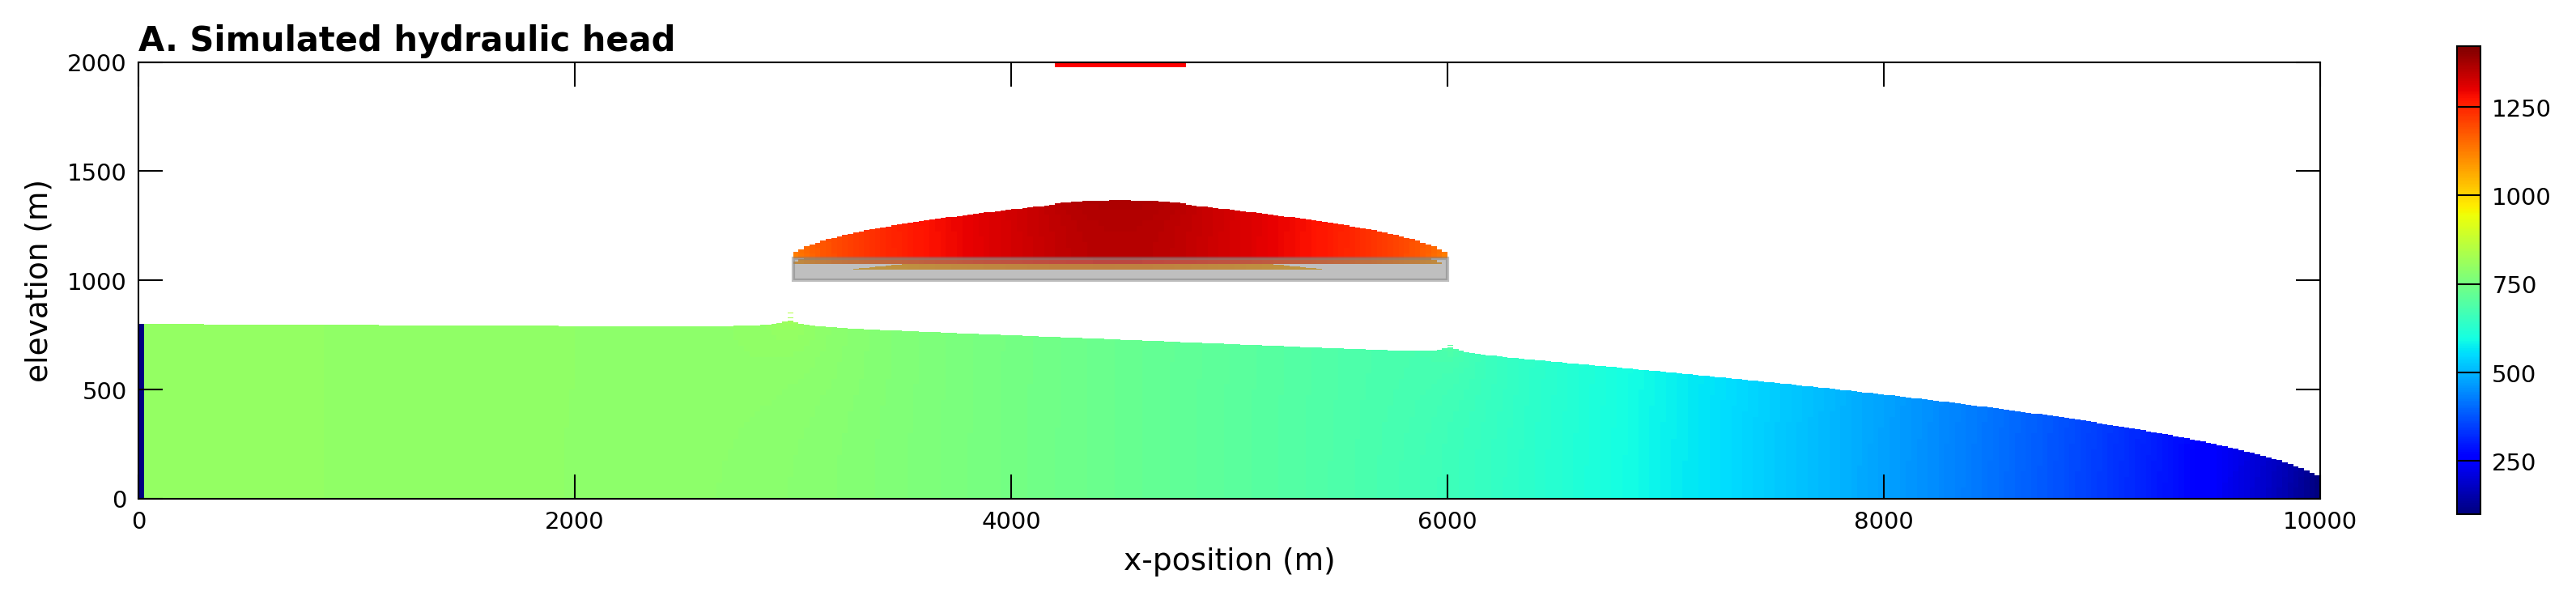

In [33]:
# import styles
from flopy.plot import styles

# load head file and plot
head = gwf6.output.head().get_data()

with styles.USGSMap():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300, tight_layout=True)

    xsect = flopy.plot.PlotCrossSection(model=gwf6, ax=ax, line={"row": 0})
    pc = xsect.plot_array(head, head=head, cmap="jet")
    xsect.plot_bc(ftype="RCH", color="red")
    xsect.plot_bc(ftype="CHD")
    plt.colorbar(pc, shrink=0.25)

    # add a rectangle to show the confining layer
    confining_rect = mpl.patches.Rectangle(
        (3000, 1000), 3000, 100, color="gray", alpha=0.5
    )
    ax.add_patch(confining_rect)

    # set labels using styles
    styles.xlabel(label="x-position (m)")
    styles.ylabel(label="elevation (m)")
    styles.heading(
        letter="A.", heading="Simulated hydraulic head", fontsize=10
    )
    ax.set_aspect(1.0)

Plotting concentration model results using the `USGSMap()` style

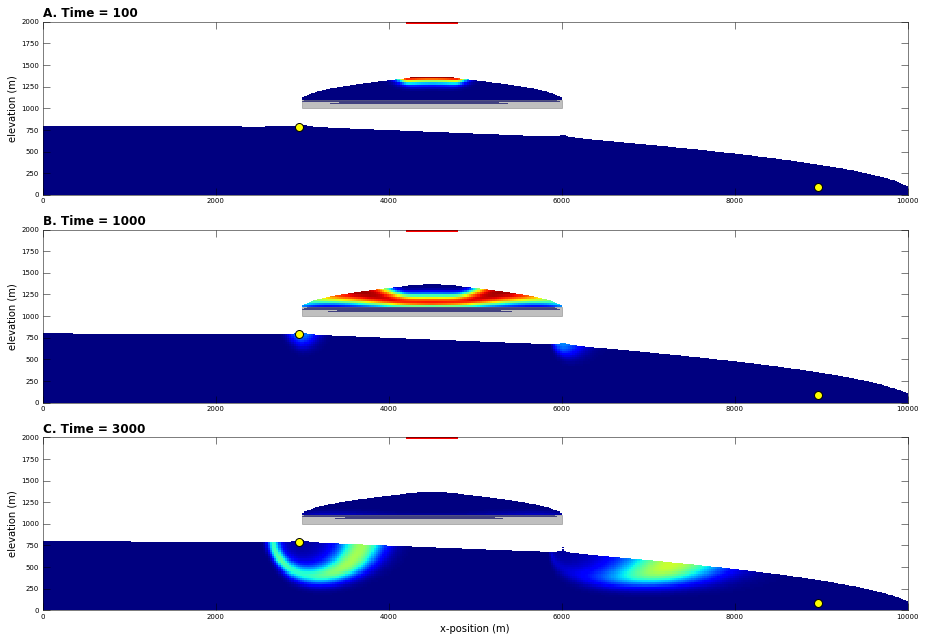

In [34]:
# load the transport output file
cobj = gwt6.output.concentration()
plot_times = [100, 1000, 3000]
obs1 = (48, 0, 118)  # Layer, row, and column for observation 1
obs2 = (76, 0, 358)  # Layer, row, and column for observation 2
xgrid, _, zgrid = gwf6.modelgrid.xyzcellcenters


with styles.USGSPlot():
    fig, axes = plt.subplots(3, 1, figsize=(15, 9), tight_layout=True)
    for ix, totim in enumerate(plot_times):
        heading = "Time = {}".format(totim)
        conc = cobj.get_data(totim=totim)
        ax = axes[ix]
        xsect = flopy.plot.PlotCrossSection(model=gwf6, ax=ax, line={"row": 0})
        pc = xsect.plot_array(conc, head=head, cmap="jet", vmin=0, vmax=1)
        xsect.plot_bc(ftype="RCH", color="red")
        xsect.plot_bc(ftype="CHD")

        # plot confining layer
        confining_rect = mpl.patches.Rectangle(
            (3000, 1000), 3000, 100, color="gray", alpha=0.5
        )
        ax.add_patch(confining_rect)

        # set axis labels and title using styles
        styles.ylabel(ax=ax, label="elevation (m)", fontsize=10)
        if ix == 2:
            styles.xlabel(ax=ax, label="x-position (m)", fontsize=10)
        styles.heading(ax=ax, heading=heading, idx=ix, fontsize=12)

        ax.set_aspect(1.0)

        # add observation locations based on grid cell centers
        for k, i, j in [obs1, obs2]:
            x = xgrid[i, j]
            z = zgrid[k, i, j]
            ax.plot(x, z, mfc="yellow", mec="black", marker="o", ms="8")

## Summary

This notebook demonstrates some of the plotting functionality available with flopy.  Although not described here, the plotting functionality tries to be general by passing keyword arguments passed to the `PlotCrossSection` methods down into the `matplotlib.pyplot` routines that do the actual plotting.  For those looking to customize these plots, it may be necessary to search for the available keywords by understanding the types of objects that are created by the `PlotCrossSection` methods.  The `PlotCrossSection` methods return these matplotlib.collections objects so that they could be fine-tuned later in the script before plotting.

Hope this gets you started!

In [35]:
try:
    # ignore PermissionError on Windows
    tempdir.cleanup()
except:
    pass